<a href="https://colab.research.google.com/github/sharminnipu/TB_Detection_MobileNet_Model/blob/master/TB_Detection_Mobile_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#get the data from dropbox
#!wget https://www.dropbox.com/s/2g2bx2rgzfe2c3c/BrainTumorData.zip?dl=0
!wget https://www.dropbox.com/s/4fvq11uqg0qrv3c/TB_IMAGES.zip?dl=0

In [ ]:
!unzip /content/TB_IMAGES.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: Tuberculosis/PNEUMONIA/person935_virus_1597.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person88_virus_166.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person900_virus_1554.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person951_virus_1622.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person898_bacteria_2823.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person940_bacteria_2865.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person921_virus_1578.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person952_bacteria_2877.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person983_bacteria_2910.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person927_virus_1584.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person960_virus_1633.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person88_virus_167.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person969_virus_1643.jpeg  
  inflating: Tuberculosis/PNEUMONIA/person

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
#count the number of images in the respective classes 0-Brain tumout and 1-Healthey
#ROOT_DIR="/content/brain_tumor_dataset"
ROOT_DIR="/content/Tuberculosis"
number_of_images={}
for dir in os.listdir(ROOT_DIR):
  # number_of_images[dir]=os.listdir(os.path.join(ROOT_DIR,dir))
 number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

In [ ]:
number_of_images.items()

dict_items([('PNEUMONIA', 3875), ('NORMAL', 1341)])

# we will split the data such that 
 * 70% for Train Data
 * 15% for Validation
 * 15% for Testing

In [ ]:
def dataFolder(p,split):
  # we will create a train folder
    if not os.path.exists("./"+p):
       os.mkdir("./"+p)

       for dir in os.listdir(ROOT_DIR):
          os.makedirs("./"+p+"/"+dir)
          for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)),
                                      size=(math.floor(split*number_of_images[dir])-5),replace=False):
              O=os.path.join(ROOT_DIR,dir,img) #path
              D=os.path.join("./"+p,dir)
              shutil.copy(O,D)
              os.remove(O)
    else:
        print(f"{p} folder exist")


In [ ]:
dataFolder("train",0.7)

In [ ]:
dataFolder("val",0.15)

In [ ]:
dataFolder("test",0.15)

Preparing our data using Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

In [ ]:

def preprocessingImages1(path):
  """
  input:Path
  output:Pre processing images
  """
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,preprocessing_function=preprocess_input,horizontal_flip=True)#data Augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image




In [ ]:
path="/content/train"
train_data=preprocessingImages1(path)

Found 3640 images belonging to 2 classes.


In [ ]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
def preprocessingImages2(path):
  """
  input:Path
  output:Pre processing images
  """
  image_data=ImageDataGenerator(preprocessing_function=preprocess_input)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')

  return image

In [ ]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 772 images belonging to 2 classes.


In [ ]:
path="/content/val"
val_data=preprocessingImages2(path)

Found 772 images belonging to 2 classes.


Model Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plot
from keras.layers  import Flatten,Dense
from keras.models import Model,load_model
from keras.applications.mobilenet import MobileNet
import keras


In [ ]:
base_model=MobileNet(input_shape=(224,224,3),include_top=False)


                  

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
X=Flatten()(base_model.output)
X=Dense(units=1,activation='sigmoid')(X)


model=Model(base_model.input,X)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [ ]:
#Early stopping and Model Check point
from keras.callbacks import ModelCheckpoint,EarlyStopping

#model check point
ms=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=1,save_best_only=True)
#early stopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1)

cd=[ms,es]

In [ ]:
hs=model.fit_generator(generator=train_data,
                       steps_per_epoch=8,
                       epochs=30,
                       verbose=1,
                       validation_data=val_data,
                       validation_steps=16,
                       callbacks=cd) 

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.9297
Epoch 1: val_accuracy did not improve from 0.92773
8/8 [==============================] - 16s 2s/step - loss: 0.5847 - accuracy: 0.9297 - val_loss: 1.6868 - val_accuracy: 0.8203
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.9961 - accuracy: 0.8398
Epoch 2: val_accuracy did not improve from 0.92773
8/8 [==============================] - 10s 1s/step - loss: 1.9961 - accuracy: 0.8398 - val_loss: 0.5285 - val_accuracy: 0.9258
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.8867
Epoch 3: val_accuracy did not improve from 0.92773
8/8 [==============================] - 10s 1s/step - loss: 0.9642 - accuracy: 0.8867 - val_loss: 0.5953 - val_accuracy: 0.9121
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 2.3508 - accuracy: 0.8516
Epoch 4: val_accuracy did not improve from 0.92773
8/8 [==============================] - 10s 1s/s

In [ ]:
# Model Accuracy
from keras.models import load_model
model=load_model("/content/bestmodel.h5")

In [ ]:
acc=model.evaluate_generator(test_data)[1]
print(f"the accuracy of our model is {acc *100} %")


the accuracy of our model is 93.1347131729126 %


In [ ]:
# Model Graphical Interpretation
h=hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

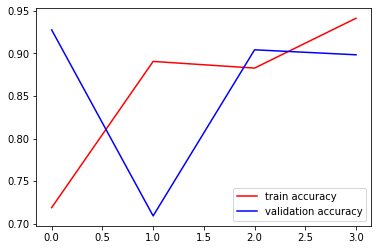

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'], c = "red",label="train accuracy")

plt.plot(h['val_accuracy'], c = "blue",label="validation accuracy")

plt.legend()
plt.savefig('acc_val_acc.png')
plt.show()

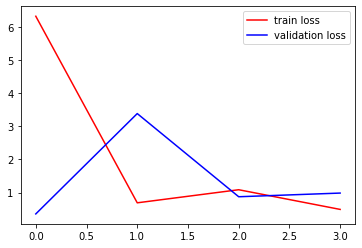

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h['loss'], c = "red",label="train loss")

plt.plot(h['val_loss'], c = "blue",label="validation loss")

plt.legend()
plt.show()

#Model prediction

In [ ]:
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img,img_to_array

In [ ]:
path="/content/Tuberculosis/PNEUMONIA/person1180_bacteria_3128.jpeg"
img=load_img(path,target_size=(224,224))
input_arr=img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape
input_arr=np.expand_dims(input_arr,axis=0)

predictions = (model.predict(input_arr)>0.5).astype("int32")

#predictions = (model.predict(x_test) > 0.5).astype("int32") for 1
predictions

if predictions== 0:
   print("The X-RAY is no having TB")

else:
   print("The X-RAY is having TB")


FileNotFoundError: ignored